In [1]:
import ROOT as R

Welcome to JupyROOT 6.24/02


Sampling a PDF (probability density function) to generate pseudo data/pseudo experiments
====

**Create a PDF**  <br>
We'll use our PDF to create *pseudo experiment* data distributions to test various tools that can be applied to the data.

In [2]:
tc=R.TCanvas()
pi=R.TMath.Pi()

In [3]:
xmin=-pi/16; xmax=1.2*pi
# Create a function with 1 free parameter. We'll use this as our PDF
fsin = R.TF1("fsin", "[0]*(sin(x)*sin(x)+sin(1.5*x)*sin(1.5*x))*exp(-x/2)", xmin, xmax) 

In [4]:
fsin.SetParameter(0,1)
fsinNorm=1.0/fsin.Integral(xmin,xmax)
fsin.SetParameter(0,fsinNorm)  # normalize to unit area
fsin.SetMinimum(0)   # fix minimum value of y-axis to 0
fsin.SetTitle("Some PDF: fsin;x;PDF(x)")

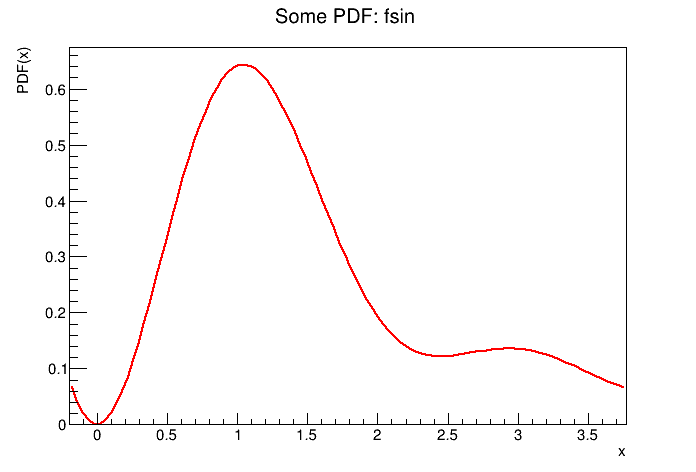

In [5]:
fsin.Draw()
tc.Draw()

**Generate some pseudodata using our PDF** <br>
You can think about what we will do in the following way.  The function **fsin** represents some model of a *true* underlying process.  We perform an experiment that measures the process a discrete number of times (**ntrials** below).  

An experiment (even a perfect experiment with no measurement errors) can never fully measure the *true* or *parent* probability distribution.  Through experiments, we can sample the *parent* probability distribution, and our observation is called the *sample distribution*.

* With a small number of samples, statistical uncertainties will dominate the precision of our observations.  
* With a very large number of samples, the sample distribution will approach the parent distribution.  An important caveat is that imperfections in our experimental appararus will eventually become the dominant source of our uncertainty. 

In [6]:
# generate a pseudoexperiment (PE) with ntrials samples
# call this function to generate a new PEs
def GenPE(ntrials=1000,nbins=10):
    hpdata=R.TH1F("hpdata","Pseudo data",nbins,xmin,xmax)
    hpdata.SetMinimum(0)
    for i in range(ntrials): hpdata.Fill(fsin.GetRandom(xmin,xmax))
    return hpdata

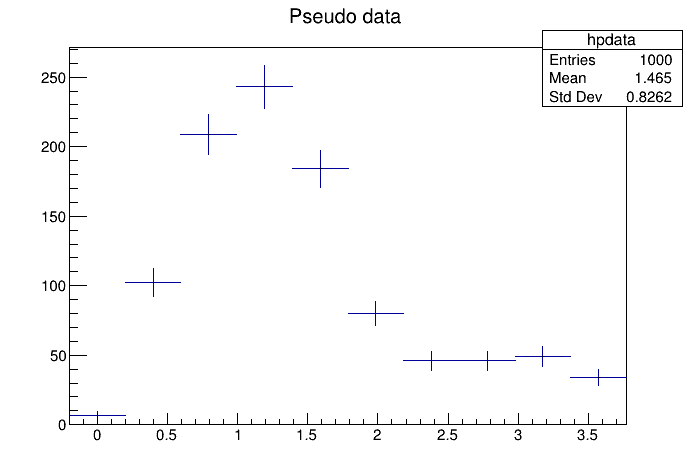

In [7]:
# Example of a pseudo experiment composed of randomly generated data
# rerun this cell to generate a new PE
hpdata=GenPE()
hpdata.Draw("e")
tc.Draw()

**Next let's overlay the expectation for the true distribution on this pseudoexperiment.**

Normalizations can be a little tricky when scaling your PDFs at match a certain normaliation in histogrammed data.  This is because the number of bins choosen affects the height of the data distributions, for example if you double the number of bins, the high is the histogram bins will be reduced by ~a factor of 2.  Below the normalization of the pdf is corrected as follows:
* Extract the histogram that is used to draw the function and normalize it to unit area.
* Scale this histgram by *ntrials* and also by the ratio of bins in the used to draw the function and the data.
* Now any changes in the numebr bins used to plot the data, the number of trials, or the number of points used to plot the function (see [TH1F::SetNPx()](https://root.cern.ch/doc/master/classTF1.html#aea3c928ccaf8b32b1554d2b84158238e)) will automatically be corrected to get the correct normalization for plotting.

In [8]:
def NormPDF(hpdata,pdf):
    fplot=pdf.GetHistogram()
    fplot.Scale(1./fplot.Integral())
    fplot.Scale(hpdata.Integral()*fplot.GetNbinsX()/hpdata.GetNbinsX())
    return fplot

def PlotPDvPDF(hpdata,pdf,tc):
    fplot=NormPDF(hpdata,pdf)
    hpdata.Draw("e")
    hpdata.Draw("e")
    fplot.Draw("same,hist,c")
    tc.Draw()

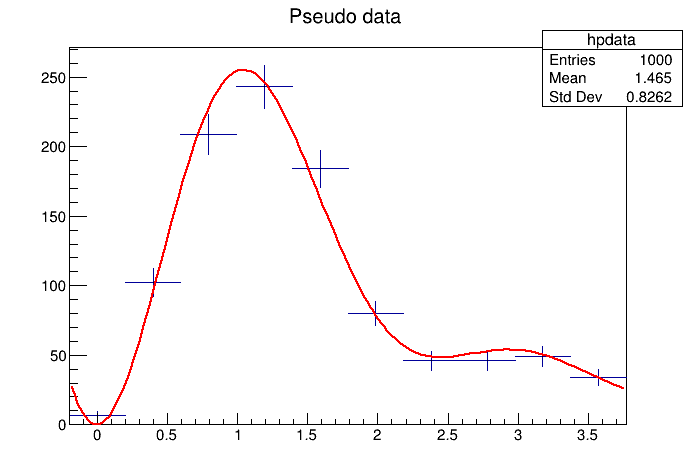

In [9]:
PlotPDvPDF(hpdata,fsin,tc)

**Now let's generate a new pseudodata set**

Warning in <TROOT::Append>: Replacing existing TH1: hpdata (Potential memory leak).


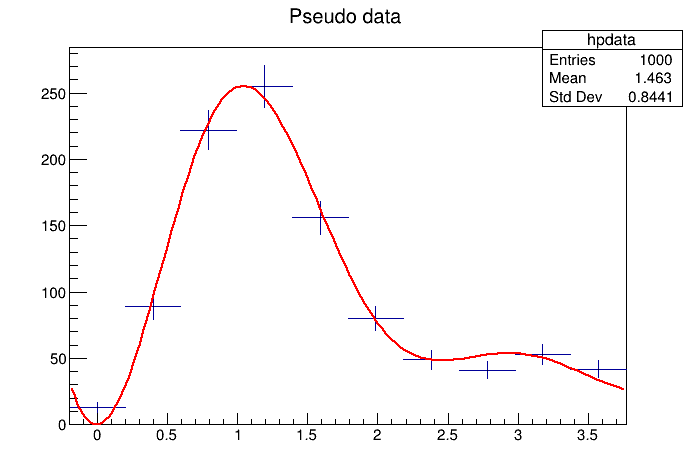

In [10]:
hpdata=GenPE()
PlotPDvPDF(hpdata,fsin,tc)

Interpolations
====

We'll call some C++ code to implement Lagrange interpolation.  The order of the interpolation can be selected.

In [11]:
R.gROOT.ProcessLine(".L Lagrange.cpp+")

0

Info in <TUnixSystem::ACLiC>: creating shared library /home/hirosky/GIT/phys5630/fits0/./Lagrange_cpp.so
Warning in cling::IncrementalParser::CheckABICompatibility():
  Possible C++ standard library mismatch, compiled with __GLIBCXX__ '20200312'
  Extraction of runtime standard library version was: '20210601'
/home/hirosky/miniconda3/envs/phys56xx/bin/../lib/gcc/x86_64-conda-linux-gnu/9.4.0/../../../../x86_64-conda-linux-gnu/bin/ld: /lib64/libmvec.so.1: unknown type [0x13] section `.relr.dyn'
/home/hirosky/miniconda3/envs/phys56xx/bin/../lib/gcc/x86_64-conda-linux-gnu/9.4.0/../../../../x86_64-conda-linux-gnu/bin/ld: skipping incompatible /lib64/libmvec.so.1 when searching for /lib64/libmvec.so.1
/home/hirosky/miniconda3/envs/phys56xx/bin/../lib/gcc/x86_64-conda-linux-gnu/9.4.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find /lib64/libmvec.so.1
/home/hirosky/miniconda3/envs/phys56xx/bin/../lib/gcc/x86_64-conda-linux-gnu/9.4.0/../../../../x86_64-conda-linux-gnu/bin/ld: /lib64/libm

In [12]:
import numpy as np

orders=[1,2,5,8]  # different orders of interpolation to test
#order=1 # linear interpolation
#order=3 # cubic interpolation
tgi=[]   # python list to be filled with different TGraphs

# our interpolation function requires us to x,y arrays instead of a histogram
x=np.zeros(hpdata.GetNbinsX(),dtype=np.double)
y=np.zeros(hpdata.GetNbinsX(),dtype=np.double)
ex=np.zeros(hpdata.GetNbinsX(),dtype=np.double)
ey=np.zeros(hpdata.GetNbinsX(),dtype=np.double)
for i in range(hpdata.GetNbinsX()):
    x[i]=hpdata.GetBinCenter(i+1)
    y[i]=hpdata.GetBinContent(i+1)
    ex[i]=hpdata.GetBinWidth(i+1)/2
    ey[i]=hpdata.GetBinError(i+1)
    
nInterp=100 # number of points for calculation of interpolated values
step=(x[-1]-x[0])/nInterp  # step sixe for intepolated values
# these arrays will store the x,y values for the interpolated data
xi=np.array(range(nInterp),dtype=np.double)
xi=xi*step+x[0]
yi=np.zeros(nInterp,dtype=np.double)

In [13]:
# scan difference orders of the Lagrange interpolation and save the reults in TGraphs
for i in range(len(orders)): 
    for nx in range(nInterp):
        yi[nx]=R.LgInterp(xi[nx],x,y,len(x),orders[i])
    tgi.append(R.TGraph(len(xi),xi,yi))
    tgi[i].SetLineColor(i+1)

AttributeError: Failed to get attribute LgInterp from ROOT

In [ ]:
# plot the results of our interpolations to the data and compare with the true distribution
hpdata.SetStats(0)
hpdata.SetMinimum(-hpdata.GetMaximum()/10)  # to show undershoot of large order interpolation
hpdata.Draw("e")
tl=R.TLegend(0.7,0.5,0.9,0.9)
for i in range(len(orders)): 
    tgi[i].Draw("l")
    tl.AddEntry(tgi[i],"order="+str(orders[i]),"l")
fplot=NormPDF(hpdata,fsin)
fplot.SetLineStyle(2)
fplot.SetLineColor(R.kYellow-3)
tl.AddEntry(fplot,"Truth","l")

In [ ]:
fplot.Draw("same,hist,c")
tl.Draw()
tc.Draw()

**Examine the performace of a spline interpolation**

In [ ]:
# make a TGraph of our data
grdata=R.TGraphErrors(len(x),x,y,ex,ey)
for nx in range(nInterp):
    yi[nx]=grdata.Eval(xi[nx],0,"S")  # built in 3-spline interpolation
tgs=R.TGraph(len(xi),xi,yi)
tgs.SetTitle("3-Spline interpolation;x")
tl=R.TLegend(0.7,0.7,0.9,0.9)
tl.AddEntry(tgs,"Spline","l")
tl.AddEntry(fplot,"Truth","l")

In [ ]:
tgs.Draw("al")
grdata.Draw("*")
fplot.Draw("same,hist,c")
tl.Draw()
tc.Draw()